In [72]:
# Import machine learning and dataset modules
import torch
import tarfile
import path
import os
import re

import torch.nn as nn
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
# Enable PyTorch to use CUDA cores if they are avialable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class ToTensor:
    # Convert ndarrays to Tensors
    def __call__(self, sample):
        inputs, targets = sample
        return torch.from_numpy(inputs), torch.from_numpy(targets)

In [127]:
# Implement custom dataset loader for synthetic data
class SyntheticDataset(Dataset):
    def __init__(self, tar_path='data/synthetic.tar.gz', transform=None):
        self.X = []
        self.y = []
        self.transform = transform
        
        regex = re.compile(r'((.*?)[0-9]{5})')
        
        with tarfile.open(tar_path) as tar:
            for member in tar.getmembers():
                if member.isfile():
                    f = tar.extractfile(member)
                    fn = member.name
                    bn = os.path.basename(fn)
                    uuid = os.path.basename(Path(fn).parent)
                    df = pd.read_csv(f)
                    
                    # If filename is features.csv, append to y tensor
                    if 'features.csv' in bn:
                        df.drop(['population', 'backend'], axis=1, inplace=True)
                        df['network_name'] = [regex.search(x).group(1) for x in df['network_name']]
                        self.y.append(df)
                        
                    # If filename is timeseries.csv, append to X tensor
                    if 'timeseries.csv' in bn:
                        df['uuid'] = uuid
                        
                        # Add columns together to make SEIR data
                        df['infected'] = df['infected'] + df['hospitalized'] + df['icu'] + df['carrier']
                        df['recovered'] = df['recovered'] + df['dead']
                        
                        df.drop(['timestamp', 'hospitalized', 'icu', 'dead', 'carrier'], axis=1, inplace=True)
                        self.X.append(df)
        
        self.y = pd.concat(self.y)
        self.X = pd.concat(self.X)
        
        self.network_mapping = {k: v for v, k in enumerate(self.y['network_name'].unique())}
        self.y['network_enum'] = self.y['network_name'].map(self.network_mapping)
        
        self.y.reset_index(inplace=True)
        self.X.reset_index(inplace=True)
        
        self.y_data = self.y.drop(['network_name'], axis=1).to_numpy(dtype=np.float32)
        
        # Stackoverflow magic
        g = self.X.groupby('uuid').cumcount()
        self.X_data = (self.X.set_index(['uuid', g])
            .unstack(fill_value=-1).stack()
            .groupby(level=0)
            .apply(lambda x: x.values.tolist())
            .tolist())
        
        self.X_data = np.array(self.X_data, dtype=np.int)
        self.X_data = self.X_data[:, :, 1:]
    
    def __getitem__(self, index):
        sample = self.X_data[index], self.y_data[index]
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
        
    def __len__(self):
        return len(self.y)

In [156]:
def plot_timeseries(ts):
    n = 0
    for step in ts:
        if step[0] == -1:
            break
        n+=1
    df = pd.DataFrame(ts[:n].numpy(), columns=['susceptible', 'exposed', 'infected', 'recovered'])
    df.plot()
    plt.show()

In [152]:
# Split up training, validation, and testing dataset
whole_set = SyntheticDataset(transform=ToTensor())

l = len(whole_set)

# training = 50%, validation = 20%, testing = 30%
n_val = int(0.2*l)
n_test = int(0.3*l)
n_train = l - n_test - n_val

train_set, val_set, test_set = random_split(whole_set, [n_train, n_val, n_test])

In [153]:
# Hyperparameters
batch_size = 4

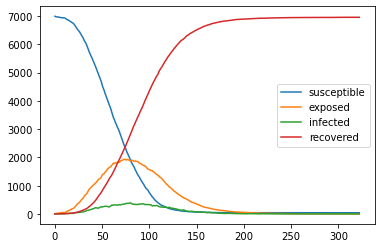

In [164]:
# Dataset loaders and sanity check with plots
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

a = iter(train_loader)
ts, features = a.next()

plot_timeseries(ts[1])